In [1]:
# Import 3rd-party frameworks.

from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import time as tm
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Import the Bot engine.
import sys 
sys.path.append('..')
from ___Engine import *
Engine.ChooseMode(stream=True, show_stream=False, demisser=True, show_demosser=False, traders=True, show_tranders=False, present=True )

engine = Engine()
engine.Start(Config['structure'], Config['timing'])

bn = None
if len(engine.exchanges) > 0:
    bn = engine.exchanges[0]  # Binance exchange

====== Bot: engine is created.
====== Bot: engine is starting...
Initializing Binance singleton...
+++++ klines.ALICEUSDT.1m is newly added to gstreams.
+++++ klines.DOTUSDT.1m is newly added to gstreams.
+++++ klines.1INCHUSDT.1m is newly added to gstreams.
+++++ klines.BTCUSDT.1m is newly added to gstreams.
+++++ klines.ETHUSDT.1m is newly added to gstreams.
+++++ klines.MATICUSDT.1m is newly added to gstreams.
====== Bot: Traders, and their strategies/indicators, are created.
====== Bot: Sleeping 0.0 seconds before launching the time machine.
====== Bot starting a new round.

====== Bot: Traders, and their strategies/indicators, are running...
====== Indicator - (3, 1, 1 - Prices_Stream): step 0, currInterval 0
====== Indicator - (2, 1, 1 - GoodIndicator): step 0, currInterval 0
2023-03-29 17:31:50: --- (2, 1, 1 - GoodIndicator): Finished 0-th round.
====== Indicator - (1, 1, 1 - SimpleIndicator): step 0, currInterval 0
====== Indicator - (1, 2, 1 - GoodIndicator): step 0, currInter

Release unicorn-binance-websocket-api_1.43.3 is available, please consider updating! (Changelog: https://github.com/LUCIT-Systems-and-Development/unicorn-binance-websocket-api/blob/master/CHANGELOG.md)Release unicorn-binance-websocket-api_1.43.3 is available, please consider updating! (Changelog: https://github.com/LUCIT-Systems-and-Development/unicorn-binance-websocket-api/blob/master/CHANGELOG.md)



## 1. Collect price candles seamlessly

"No model is better than the underlying data."

In [4]:
# Get_Price_Data_By_Time function seamlessly collects/creates price candles from Binance.

start = datetime(2023, 1, 1)    # Any datetime. Note Binance started operation in July 2017.
end = datetime(2023, 3, 16)     # Any datetime
symbol = "BTCUSDT"      # Any pair listed on Binance.
interval = "1m"         # in '1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d'.  (excludes: '3d', '1w')
prePad = True           # prepend with null candles.
#------------------------------------------------------------------------------------------------------------------
candles, nFills, successful, _, _ = bn.Get_Price_Data_By_Time("klines", symbol, interval, start, end, prePad=prePad)
if successful:          # price is a numpy array.
    print("\n!!!!!!!!!! (nCandles, nAttributes) = {}, nCreated = {}".format(candles.shape, nFills))

Get_Price: klines.BTCUSDT.1m.2023-01-01 00:00:00.2023-03-16 00:00:00
Extrapolated candles will be created if initial candles are not available...

!!!!!!!!!! (nCandles, nAttributes) = (106561, 12), nCreated = 0


In [6]:
# Get_Price_Data_By_Time_Batch function executes a batch of Get_Price_Data_By_Time calls.

start = datetime(2023, 1, 1)
end = datetime(2023, 3, 15)
symbols = ["BTCUSDT", "ETHUSDT"]    # Be careful with market symbols.
interval = "1m"
#-------------------------------------------------------------------------------------------------------
table, nFills, successful_symbols, succesful, = bn.Get_Price_Data_By_Time_Batch("klines", symbols, interval, start, end)
if succesful:   # table is a numpy array.
    print("\n!!!!!!!!!! (nMarkets, nCandles, nAttributes) = {}, nCreated = {}".format(table.shape, nFills))
    print("\n!!!!!!!!!! successful: {}".format(successful_symbols))

Walking through the list...
Get_Price: klines.BTCUSDT.1m.2023-01-01 00:00:00.2023-03-15 00:00:00
Extrapolated candles will be created if initial candles are not available...
Get_Price: klines.ETHUSDT.1m.2023-01-01 00:00:00.2023-03-15 00:00:00
Extrapolated candles will be created if initial candles are not available...

Successful for 2/2 markets

!!!!!!!!!! (nMarkets, nCandles, nAttributes) = (2, 105121, 12), nCreated = 0

!!!!!!!!!! successful: ['BTCUSDT: 105121, 0 created. Success.', 'ETHUSDT: 105121, 0 created. Success.']


In [7]:
def ShowSingle(title, series):
    fig = plt.figure(figsize=(16,3))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    for line in series:
        ax.plot(line[0], label = line[1], color=line[2])
    ax.legend()
    plt.show()

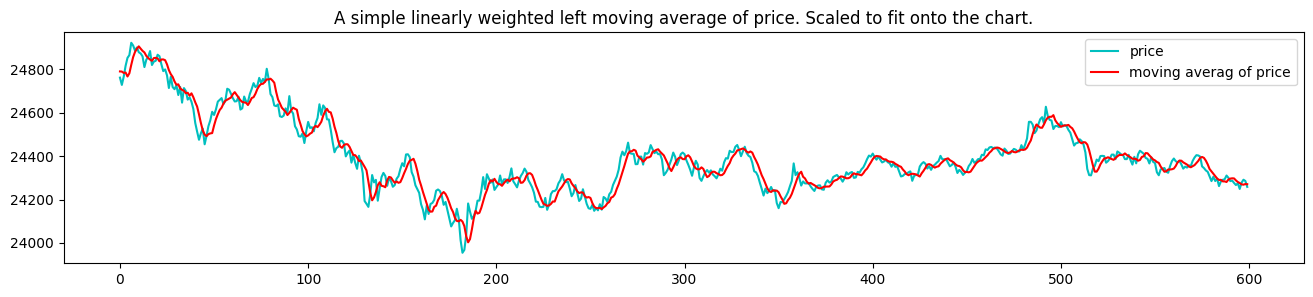

In [8]:
# Show a simple linearly weighted left moving average, ma, of closing prices.

p = 5             # period of moving average
nLatest = 600    # the number of candles to show

#----------------------------------------------------------------------------------
p = min(candles.shape[0], p)
nLatest = min(candles.shape[0] - (p-1), nLatest)

closes = candles[:,4]
maP = np.convolve(closes, np.array(range(1, p+1, 1)), mode="valid") / (p*(p+1)/2)
series = [ (closes[-nLatest:], 'price', 'c'), (maP[-nLatest:], 'moving averag of price', 'r') ]
ShowSingle("A simple linearly weighted left moving average of price. Scaled to fit onto the chart.", series)

## 2. Easier learning with event-free price data

In [9]:
def Event_Free_Learning_Scheme(candles, smallSigma, largeSigma, nLatest):
    # Show a Gaussian-weighted left moving average of closing prices.

    def gaussian( x, s): return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

    smallSigma = min(math.floor(candles.shape[0]/3), smallSigma)
    smallP = 3 * smallSigma
    smallKernel = np.fromiter( (gaussian( x , smallSigma ) for x in range(-smallP+1, 1, 1 ) ), float ) # smallP points, incl 0.
#     print("smallKernel: {}".format(smallKernel))
    maP = np.convolve(candles[:, 4], smallKernel, mode="valid") / np.sum(smallKernel) # maps to candles[smallP-1:]
    log_maP = np.log2(maP + 1e-9) # maps to candles[smallP-1:]

    largeSigma = min(math.floor(candles.shape[0]/3), largeSigma)
    largeP = 3 * largeSigma
    largeKernel = np.fromiter( (gaussian( x , largeSigma ) for x in range(-largeP+1, 1, 1 ) ), float ) # largeP points, incl 0.
#     print("largeKernel: {}".format(largeKernel))
    event = np.convolve(log_maP, largeKernel, mode="valid") / np.sum(largeKernel) # maps to log_maP[largeP-1:], so to candles[smallP+largeP-2:]

    assert event.shape[0] == candles.shape[0] - (smallP+largeP-2)
    log_maP1 = log_maP[largeP-1:] # maps to log_maP[largeP-1:], so to candles[smalP+largeP-2:]
    assert log_maP1.shape[0] == candles.shape[0] - (smallP+largeP-2)
    P1 = candles[smallP+largeP-2:, 4]
    assert P1.shape[0] == candles.shape[0] - (smallP+largeP-2)
    eventFree = log_maP1 - event # maps to candles[smallP+largeP-2:]

    nLatest = min(candles.shape[0] - (smallP+largeP-2), nLatest)
    P2 = P1[-nLatest:]
    maP2 = maP[-nLatest:]
    logP2 = np.log2(P2 + 1e-9)
    log_maP2 = log_maP1[-nLatest:]
    event2 = event[-nLatest:]
    eventFree2 = eventFree[-nLatest:] # maps to candle[p1-1+p2-1+begin: p1-1+p2-1+begine+width]

    minEF = np.min(eventFree2); maxEF = np.max(eventFree2)
    minP = np.min(P2); maxP = np.max(P2)
    P3 = (P2-minP) / max(maxP-minP, 1e-9) * (maxEF-minEF)
    minMP = np.min(maP2); maxMP = np.max(maP2)
    maP3 = (maP2-minMP) / max(maxMP-minMP, 1e-9) * (maxEF-minEF)
    minLP = np.min(logP2); maxLP = np.max(logP2)
    logP3 = (logP2-minLP) / max(maxLP-minLP, 1e-9) * (maxEF-minEF)
    minLMP = np.min(log_maP2); maxLMP = np.max(log_maP2)
    log_maP3 = (log_maP2-minLMP) / max(maxLMP-minLMP, 1e-9) * (maxEF-minEF)
    minE = np.min(event2); maxE = np.max(event2)
    event3 = (event2-minE) / max(maxE-minE, 1e-9) * (maxEF-minEF)
    eventFree3 = eventFree2 - minEF

    series = [
        (maP3, "maP", "g"), (log_maP3, "log.maP", "b"), (event3, "event = MA(log.maP))", "c"), (eventFree3, "e.Free = log.maP - event", "brown")
    ]
    ShowSingle("Event-free (brown) series is relatively stable, vibrating around a fixed axis. Scaled to fit onto the chart.", series)

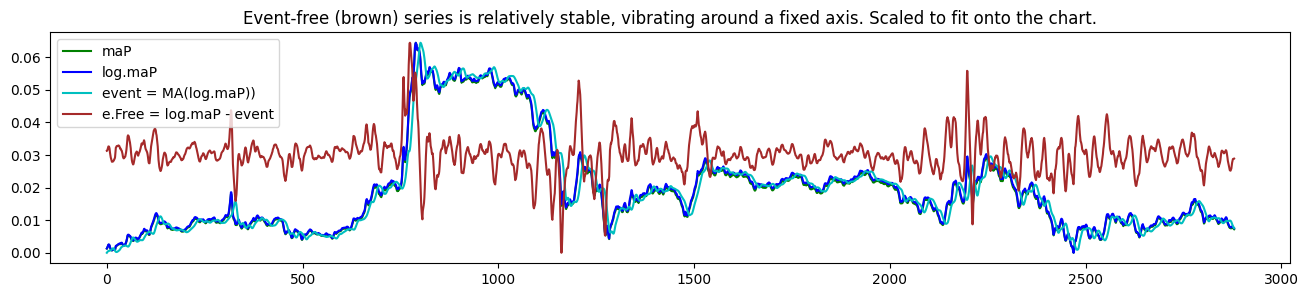

In [10]:
# Assess if event-free series has significance, and at what sigma values.

smallSigma = 3
largeSigma = 5
nLatest = 1440 * 2   # the number of candles to show.
#-----------------------------------------------------------------
Event_Free_Learning_Scheme(candles, smallSigma, largeSigma, nLatest)

In [11]:
# - maP: shorter past moving average of price
# - event = MA(log.maP): longer past moving agverage of the logarithm of smooth price
# - e.Free = log.maP - event = log.maP - MA(log.maP): event-free maP, which is easier to predict
# - Once we predict e.Free, then maP = exp(e.Free + event)

# - Shortcomings:
#   - Delay, coming from moving average.
#   - Reason to use moving average: filter out extrem, high-frequency noise.

## 3. Quick fetch of candle `data`

Get_Price: klines.BTCUSDT.1m.2023-03-29 16:39:20.068642.2023-03-29 17:38:20.068642
!!!!! SUCCESS. nCreated/nTotal/expected 0/60/60


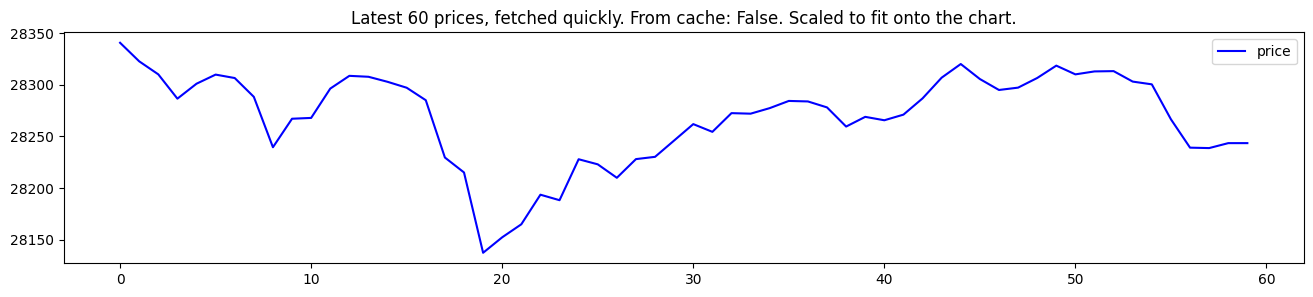

In [13]:
# Get the latest pirces, so quickly as to draw and monitor all 330 -/USDT markets on Binance in real time.

nLatest = 60 * 1    # number of latest candles to fetch
#--------------------------------------------------------------

end = datetime.now() # datetime(2023, 2, 20)
start = end - timedelta(minutes=nLatest-1, hours=0)
symbol = "BTCUSDT"; interval = "1m"
price2, nFills, succesful, fromCache, _ = bn.Get_Price_Data_By_Time("klines", symbol, interval, start, end, lookup=False)
if price2 is not None:
    series = [ (price2[:,4], "price", "b") ]
    ShowSingle("Latest {} prices, fetched quickly. From cache: {}. Scaled to fit onto the chart.".format(nLatest, fromCache), series)

In [14]:
# Application - Monotor all the 230 -/USDT markets hosted by Binance exchnage

# Asset elevators: you can get on the elevator cars on any floor at any time, as the elevator has a car on all floors.
# The more asset you have, the higher floor you stay.
# If you buy BTC with USDT, you are on the BTC/USDT elevator, which goes up and down according to the BTC price.
# If you sell BTC for USDT, you are on the floor that matches your amount of asset.
# Being on a floor or an elevator, you always search for a fastest, optimal up-going elevator. Floors are a stationary elevator.
# You always move to the fastest, optimal elevator. You cannot go down, as the floors are a type of elevator and they are stationary.
# THE MORE elevators you have, THE BETTER chances of up-going you have, in terms of wating time and up-going speed.
# We will have lots of elevators, as we can monitor lots of markets at the same time.
# This is an economy of scale applied to trading.

## 4. Price and volume best combined

In [15]:
def Show_Price_Volum(pSigma, vSigma, nLatest):

    def gaussian( x, s): return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp( -x**2 / ( 2. * s**2 ) )

    pSigma = min(math.floor(candles.shape[0]/3), pSigma)
    pP = 3 * pSigma
    pKernel = np.fromiter( (gaussian( x , pSigma ) for x in range(-pP+1, 1, 1 ) ), float ) # pP points, incl 0.
    # print("pKernel: {}".format(pKernel))
    maP = np.convolve(candles[:, 4], pKernel, mode="valid") / np.sum(pKernel) # maps to candles[smallP-1:]

    vSigma = min(math.floor(candles.shape[0]/3), vSigma)
    vP = 3 * vSigma
    vKernel = np.fromiter( (gaussian( x , vSigma ) for x in range(-vP+1, 1, 1 ) ), float ) # vP points, incl 0.
    # print("vKernel: {}".format(vKernel))
    maV = np.convolve(candles[:, 7], vKernel, mode="valid") / np.sum(vKernel) # maps to log_maP[vP-1:], so to candles[pP+vP-2:]

    maP2 = maP[-nLatest:]
    minP = np.min(maP2); maxP = np.max(maP2)
    maV2 = maV[-nLatest:]
    minV = np.min(maV2); maxV = np.max(maV2)
    maP3 = maP2 - minP
    maV3 = (maV2-minV) / max(maxV-minV, 1e-9) * (maxP-minP)

    series = [ (maP3, "ma.Price", "b"), (maV3, "Ma.Volume", "brown") ]
    ShowSingle("Price and Volume look independent. Scaled to fit onto the chart.", series)

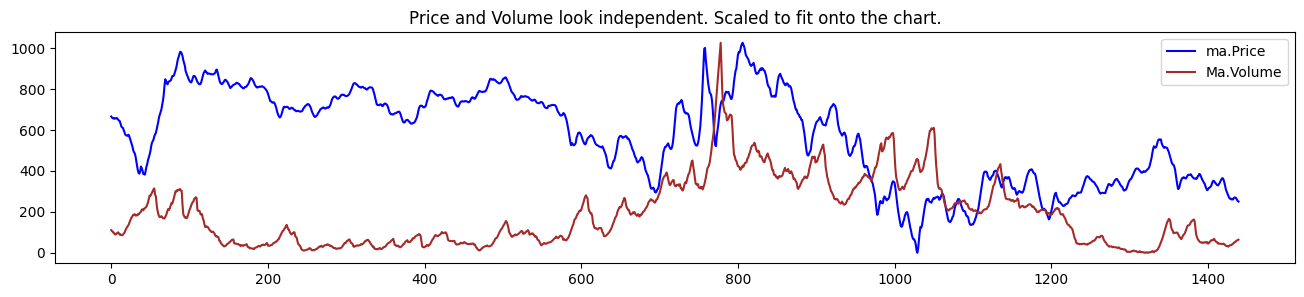

In [16]:
# Guess the best sigma for price and volume

pSigma = 3
vSigma = 10
nLatest = 1440  # minutes in a day.
#-------------------------------------------------------------------
Show_Price_Volum(pSigma, vSigma, nLatest)

In [17]:
# Logarithm of price and volume

# Neural Networks (NN) are basically a multi-layer non-linearly twisted linear combinations.
# They are more linear combinations of input data than non-linearly twist of input data.

# There is no chance of multiplication, but addition, of input A and input B, for example.

# If we input price and volume into a NN, then they are linearly combined. 
# In other words, they are sumed or subtracted to each other.
# The NN will be doing meaningless numerical play, as [ a x Price + b x Volume ] will not make a sense by no means.
# Only beginners can drive innocent, stupid NNs to sum price and volume, becasue they believe NNs are almighty.
# It will take months for them to be exhausted and stop, after a desperate network optimization and regularization play.

# Instead, we plan to multiply price with volume. Mutiplicatio of two different concept always has a meaning.
# Width x Height, Force x Lengh, Acceleration x Time, Speed x Time, etc. are examples of multiplication creating a new concept.
# In general, multiplicatio of any power of two or more physical quantities can have a meaning.
# Price x Volume, in particular, means how much is sold/bought for what price, and represents the size of transaction.

# The way to guide a NN to impelement multiplication of price and volume, is to input logarithm of price and volume.
# They will be sumed by the NN:
# a x log Price + b x log Volume 
# = log Power(Price, a) + log Power(Volume, b)
# = log ( Power(Price, a) x Power(Volume, b) ).

# So, the NN will be actually handling diversified multiplication, even including division, of price and volume, 
# beyong simple multiplication.
# The NN is powerful in finding the best weights a and b, and good at non-linearly layering these flexible multiplication layers.

# Another reason that logarithm of price and volume is a good choice:
# Whoever influences the price and volume process of markets is interested in the percentage of change, 
# rather than the absolute value of change. Traders, for example, are only interested in and driven by how many percents their asset 
# will be increased. BTC's price 60,000 USD vs. XRP's price 0.5 USD don't impress them much. Profit rate is more important than profit amount.
# Logarithm is the unique tool to suit thie requirements.


## 5. Relate market process to language process, or create a P/V BERT.

In [18]:
# Lanugage process is based on the dynamic relationship between language tokens, like words or other sequences of alphabets,
# or like sound units, or even pictures.

# While AI/ML delivers good, or surprising, utilities in diversified fields, its progress in natural language is profound and prominent.
# The Natural Language Processing techniques, like machine translation and question-answering, can "comprehend" complicated processes.
# An example is is GPT model, which is the 1st intruder to human knowledge labor. More and more software programmers rely on 
# GPT chatbots to get programming guide.

# What if we can find, at least implicitly, Price/Volume (P/V) alphabets, P/V tokens (words), and P/V sentences.
# The market process will look like the story written with P/V sentences, and could be predicted in a similar way as language 
# words and sentences are predicted in NLP.

# There is the sketch of idea:
# (market1, market2, ...) = ( BTC/USDT, XRP/USDT, ...). 
# Imagine 100 markets' candles put in parallel this way.
# Log = (log1, log2, ...) = ( [ log(BTC/USDT price), log(BTC/USDT volume) ], [ log(XRP/USDT price), log(XRP/USDT volume)], ...  )
# The market candle data looks like [ Log1, Log2, ... ], which is an infinite time-indexed sequence of Logs.
# This is a table of price and volume points arranged in markets virtically and in time points horizontally.

# Then we take into account that a word and sentence is something that is a sequence of alphabets and repetitively occurs in 
# a story. log1, log2, ... etc, which will have billions of value instances, will be grouped according to adjacent relationships.
# Each group will be our P/V token. There should be a similar process to find P/V sentences.

# Once we can transcript the historical candle data to P/V words and sentences, we can exploit the Transformer and BERT techniques,
# which was/is a huge success in NLP and resumably is the basis of GPT models.

# If we don't use NLP techniques, then we may end up with having to create traning data manually. For exmaple, we may have to 
# find sell/buy points manually from the huge amount of raw candle history of hundreds of markets. 
# (This is called tagging the data, in ML practice. They tag candle sequence data with "buy" or "sell", for example)
# It's a huge labor and time and should involve lots of tagging workers, who have different skills and criterion, leading to 
# inconsistency in training data.

# Instead of tags, the training data will be comprised of the existing language sequences, like "what words follow what words".

# Representative resources:
# - Attention Is All You Need. https://arxiv.org/pdf/1706.03762.pdf
# - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. https://arxiv.org/pdf/1810.04805.pdf
# - Auto-eocoders, and other generative models.

# Cautions
# - Natural language process doesn't change along the time axis, while market process does. In other words, a natural language 
# text has to same meaning as time passes, while price sentenses may not.

## 6. Predict staking pools

In [19]:
# Stragegy

# If 
# - the historical data of staking pools is in sufficient, 
# - or it takes long to collect the data, 
# - or it fails to predict staking pools with their limited historical data,

# then we plan to
# - get a P/C BERT model trained first until staking data becomes available,
# - and tune the P/V BERT model, by adding additional layer(s) and training on pool-specific data.


## 7. Trading bot

In [20]:
# Time tense is configurable. (TimeMachine is implemented)
# Indicators, Strategies, and Traders are configurable.

Config['timing'] = \
{
    'tense': Tense.Present,
    'intervalSec': 1.0,
    'originSec': int(datetime(year=2015, month=1, day=1, hour=0, minute=0, second=0, microsecond=0).timestamp()), # for Tense.Past only
    'intervalsPerStep': BasicIntervalMin * 60
}

Config['structure'] = \
{
    'Name': 'SimpleEngine',
    'Traders':
    {
        'Trader1': 
        {
            'Type': 'SimpleTrader',
            'Name': '(1 - SimpleTrader',
            'Cared': True,
            'Strategies':
            {
                'Strategy1':
                {
                    'Type': 'SimpleStrategy',
                    'Name': '(1, 1 - SimpleStrategy)',
                    'Indicators':
                    {
                        'Indicator1':
                        {
                            'Type': 'SimpleIndicator',
                            'Name': '(1, 1, 1 - SimpleIndicator)',
                            'GStreams' :
                            {
                                'GStream.1.1.1.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram1 (1, 1, 1, 1)',
                                    'dataType': 'klines',
                                    'symbol':   'ALICEUSDT',
                                    'interval': Config['ginterval']
                                },
                                'GStream.2.1.1.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram1 (2, 1, 1, 1)',
                                    'dataType': 'klines',
                                    'symbol':   'DOTUSDT',
                                    'interval': Config['ginterval']
                                },
                            }
                        },
                        'Indicator2':
                        {
                            'Type': 'GoodIndicator',
                            'Name': '(2, 1, 1 - GoodIndicator)',
                            'GStreams' :
                            {
                                'GStream.1.2.1.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram1 (1, 2, 1, 1)',
                                    'dataType': 'klines',
                                    'symbol':   '1INCHUSDT',
                                    'interval': Config['ginterval']
                                },
                            }
                        },
                        'Indicator3':
                        {
                            'Type': 'ProductsPrices_Stream',
                            'Name': '(3, 1, 1 - Prices_Stream)',
                            'Quote': 'USDT',
                            'MaxStreams': 3333,
                            'Interval': Config['ginterval'],
                            'Live': True,
                            'GStreams' :
                            {
                            },
                        },
#                        'Indicator4':
#                        {
#                            'Type': 'ProductsPrices',
#                            'Name': '(4, 1, 1 - Prices)',
#                            'Quote': 'USDT',
#                            'StructuralParams_Price_Thread':
#                            {
#                                
#                            },
#                            'TimingParams_Price_Thread': 
#                            {
#                                'tense': Tense.Present,
#                               'intervalSec': 1.0,
#                                'originSec': 999,
#                                'intervalsPerStep': int(Config['binance_wait_sec']),
#                            },
#                            'Interval': Config['ginterval'],
#                            'GStreams' :
#                            {
#                            },
#                        },
                    },
                },
                'Strategy2':
                {
                    'Type': 'SimpleStrategy',
                    'Name': '(2, 1 - SimpleStrategy)',
                    'Indicators':
                    {
                        'Indicator1':
                        {
                            'Type': 'GoodIndicator',
                            'Name': '(1, 2, 1 - GoodIndicator)',
                            'GStreams' :
                            {
                                'GStream.1.1.2.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram1 (1, 1, 2, 1)',
                                    'dataType': 'klines',
                                    'symbol':   'BTCUSDT',
                                    'interval': Config['ginterval']
                                },
                                'GStream.2.1.2.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram1 (2, 1, 2, 1)',
                                    'dataType': 'klines',
                                    'symbol':   'ETHUSDT',
                                    'interval': Config['ginterval']
                                },
                            }
                        },
                        'Indicator2':
                        {
                            'Type': 'GoodIndicator',
                            'Name': '(2, 2, 1 - GoodIndicator)',
                            'GStreams' :
                            {
                                'GStream.1.2.2.1':
                                {
                                    'Type': 'Binance',
                                    'Name': 'GSteram3 (1, 2, 2, 1)',
                                    'dataType': 'klines',
                                    'symbol':   'MATICUSDT',
                                    'interval': Config['ginterval']
                                },
                            }
                        },
                    },
                },
            },
        },
    },
}


In [37]:
# indicators, strategies, and traders collborate asynchronously.


# ====== Bot: Starting a new round. ---

# ====== Indicator - (1, 2, 1 - GoodIndicator): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (1, 2, 1 - GoodIndicator): Finished 2758-th round.
# ====== Indicator - (2, 2, 1 - GoodIndicator): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (2, 2, 1 - GoodIndicator): Finished 2758-th round.
# ====== Strategy - (2, 1 - SimpleStrategy): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (2, 1 - SimpleStrategy): Finished 2758-th round.
# ====== Indicator - (2, 1, 1 - GoodIndicator): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (2, 1, 1 - GoodIndicator): Finished 2758-th round.
# ====== Indicator - (3, 1, 1 - Prices_Stream): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (3, 1, 1 - Prices_Stream): Finished 2758-th round.
# ====== Indicator - (1, 1, 1 - SimpleIndicator): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (1, 1, 1 - SimpleIndicator): Finished 2758-th round.
# ====== Strategy - (1, 1 - SimpleStrategy): step 2758, currInterval 165480
# 2015-01-02 21:58:00: --- (1, 1 - SimpleStrategy): Finished 2758-th round.
# ====== Trader - (1 - SimpleTrader: step 2758, currInterval 165480
# 2015-01-02 21:58:00: ============ Bot: Finished 2758-th round. ============
# ====== Bot: Starting a new round. ---

# ====== Indicator - (1, 2, 1 - GoodIndicator): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (1, 2, 1 - GoodIndicator): Finished 2759-th round.
# ====== Indicator - (2, 2, 1 - GoodIndicator): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (2, 2, 1 - GoodIndicator): Finished 2759-th round.
# ====== Strategy - (2, 1 - SimpleStrategy): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (2, 1 - SimpleStrategy): Finished 2759-th round.
# ====== Indicator - (2, 1, 1 - GoodIndicator): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (2, 1, 1 - GoodIndicator): Finished 2759-th round.
# ====== Indicator - (3, 1, 1 - Prices_Stream): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (3, 1, 1 - Prices_Stream): Finished 2759-th round.
# ====== Indicator - (1, 1, 1 - SimpleIndicator): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (1, 1, 1 - SimpleIndicator): Finished 2759-th round.
# ====== Strategy - (1, 1 - SimpleStrategy): step 2759, currInterval 165540
# 2015-01-02 21:59:00: --- (1, 1 - SimpleStrategy): Finished 2759-th round.
# ====== Trader - (1 - SimpleTrader: step 2759, currInterval 165540
# 2015-01-02 21:59:00: ============ Bot: Finished 2759-th round. ============
# ====== Bot: Starting a new round. ---


In [38]:
# Indicators, strategies, and traders will be loaded with ML models to perform particular tasks.